# Classification Model on MNIST Dataset

## Get The Data

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

/home/praddyumnyadav/PraddyumnYadav/MachineLearning/Classification_MNIST/venv/lib64/python3.11/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

## Take a Look at the Data

In [2]:
X, y = mnist["data"], mnist["target"]
X = X.to_numpy()
y = y.to_numpy()
print(f"Shape of X = {X.shape}")
print(f"Shape of y = {y.shape}")

Shape of X = (70000, 784)
Shape of y = (70000,)


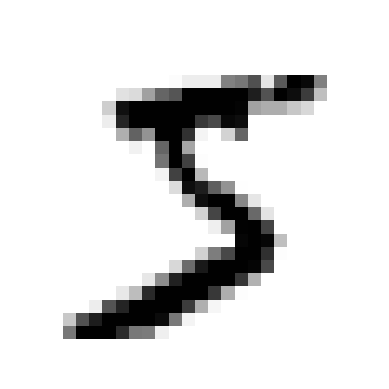

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

## Split Training and Testing Set

So Normally we Seperate our Train and Test set with so many methodes but now in the MNIST Dataset Train and Test Set is already Seperated in a way like Train set is equal to first 60,000 image and Test set is equal to last 10,000 image so we have to just Seperate That.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

### Implementing Cross-Validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


### Implementing Scikit-learns In-Built cross_val_score Function

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### Implementing Scikit-Learns In-Built BaseEstimator class

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_class = Never5Classifier()
cross_val_score(never_5_class, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade-off

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

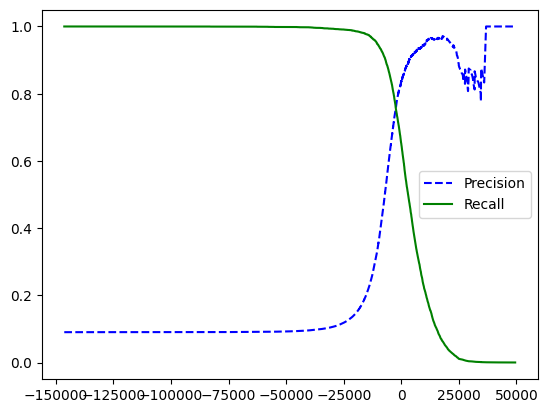

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

ROC = Reciever Operating Characteristics

### Generate a ROC Curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

[]

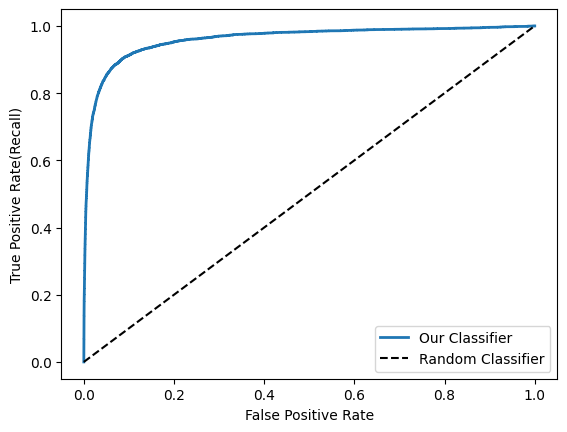

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    label = "Our Classifier"
    plt.plot(fpr, tpr, linewidth=2, label=label)
    label = "Random Classifier"
    plt.plot([0, 1], [0, 1], 'k--', label=label)
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate(Recall)', fontsize=10)
    plt.legend()

plot_roc_curve(fpr, tpr)
plt.plot()